In [246]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

# Define the impedance model for a parallel RC circuit
def impedance_model(frequency, R1, R2, C, Y0):
    omega = frequency*2*np.pi
    return R1 + 1 / (1j*omega*C + 1 / (R2 + Y0/np.sqrt(omega)*(1 - 1j)))

def real_imag_func(frequency, R1, R2, C, Y0):
    N = len(frequency)
    x_real = frequency[:N//2]
    x_imag = frequency[N//2:]
    y_real = np.real(impedance_model(x_real, R1, R2, C, Y0))
    y_imag = np.imag(impedance_model(x_imag, R1, R2, C, Y0))
    return np.hstack([y_real, y_imag])

# Read in measured impedance data
frequencies = np.array([0.997765, 2.170139, 4.650298, 9.9734, 21.50229, 45.95588,
99.734, 215.0229, 463.5989, 1000.702, 2141.204, 4630.335, 10019.53, 21621.09, 46464.84, 100019.5]) # Hz
# Z_mag = np.array([0.0138464, 0.0136741, 0.0135359, 0.0133644, 0.0130634, 0.0125438, 0.0117386,
# 0.0107635, 0.0098047, 0.0090115, 0.0085082, 0.0085248, 0.0096298, 0.0123185, 0.0163632, 0.0231264]) # Ohm
Z_real = np.array([0.0138303, 0.0136656, 0.0135265, 0.013348, 0.0130281, 0.0124733, 0.0116262, 0.0106352,
0.0097023, 0.0089637, 0.0085059, 0.0084784, 0.0093414, 0.011836, 0.0162025, 0.0229291]) # Ohm
Z_imag = np.array([-0.0006665, -0.0004833, -0.0005055, -0.0006621, -0.0009596, -0.0013285, -0.0016203, -0.0016568,
-0.001413, -0.0009269, -0.0001959, 0.0008887, 0.0023389, 0.0034139, 0.0022876, -0.0030148]) # Ohm


In [259]:
# interpolate Z_real and Z_imag to increase resolution for the non-linear least squares
end_point = 11
interp_freq = np.logspace(0, 4)
Z_real_interp = np.interp(interp_freq, frequencies[:end_point], Z_real[:end_point])
Z_imag_interp = np.interp(interp_freq, frequencies[:end_point], Z_imag[:end_point])
Z_real_spline = CubicSpline(frequencies[:end_point+1], Z_real[:end_point+1])
Z_imag_spline = CubicSpline(frequencies[:end_point+1], Z_imag[:end_point+1])
print(Z_real_interp.shape)
print(Z_imag_interp.shape)

(50,)
(50,)


In [253]:
interp_freq

array([1.00000000e+00, 1.20679264e+00, 1.45634848e+00, 1.75751062e+00,
       2.12095089e+00, 2.55954792e+00, 3.08884360e+00, 3.72759372e+00,
       4.49843267e+00, 5.42867544e+00, 6.55128557e+00, 7.90604321e+00,
       9.54095476e+00, 1.15139540e+01, 1.38949549e+01, 1.67683294e+01,
       2.02358965e+01, 2.44205309e+01, 2.94705170e+01, 3.55648031e+01,
       4.29193426e+01, 5.17947468e+01, 6.25055193e+01, 7.54312006e+01,
       9.10298178e+01, 1.09854114e+02, 1.32571137e+02, 1.59985872e+02,
       1.93069773e+02, 2.32995181e+02, 2.81176870e+02, 3.39322177e+02,
       4.09491506e+02, 4.94171336e+02, 5.96362332e+02, 7.19685673e+02,
       8.68511374e+02, 1.04811313e+03, 1.26485522e+03, 1.52641797e+03,
       1.84206997e+03, 2.22299648e+03, 2.68269580e+03, 3.23745754e+03,
       3.90693994e+03, 4.71486636e+03, 5.68986603e+03, 6.86648845e+03,
       8.28642773e+03, 1.00000000e+04])

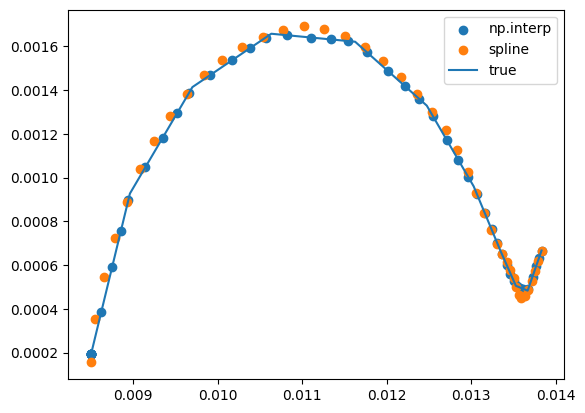

In [260]:
# plot interpolated values
plt.scatter(Z_real_interp, -1*Z_imag_interp, label='np.interp')
plt.scatter(Z_real_spline(interp_freq[:-8]), -1*Z_imag_spline(interp_freq[:-8]), label='spline')
plt.plot(Z_real[:end_point], -1*Z_imag[:end_point], label='true')
plt.legend()

In [263]:
# Fit the circuit using non-linear least squares

# original points
Z_both = np.hstack([Z_real[:end_point], Z_imag[:end_point]])
poptboth, pcovboth = curve_fit(real_imag_func, np.hstack([frequencies[:end_point], frequencies[:end_point]]), Z_both, method='lm')

# linear interpolation
# Z_both = np.hstack([Z_real_interp, Z_imag_interp])
# poptboth, pcovboth = curve_fit(real_imag_func, np.hstack([interp_freq, interp_freq]), Z_both, method='lm')

# # Spline
# Z_both = np.hstack([Z_real_spline(interp_freq[:-8]), Z_imag_spline(interp_freq[:-8])])
# poptboth, pcovboth = curve_fit(real_imag_func, np.hstack([interp_freq[:-8], interp_freq[:-8]]), Z_both, method='lm')

# Extract the fitted parameters
print("Fitted parameters: ", poptboth)

Fitted parameters:  [0.00889847 0.00407983 0.22982696 0.00210191]


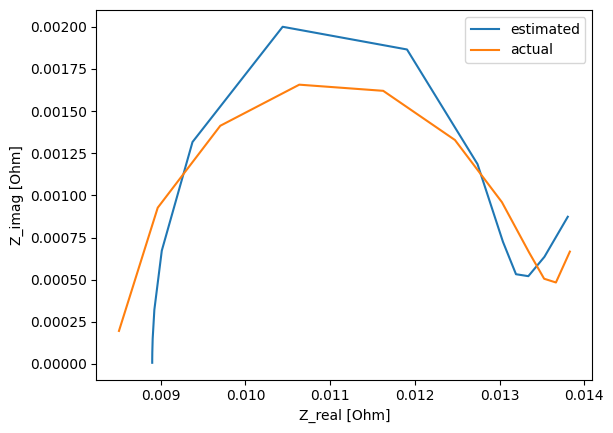

In [264]:
# plot
import matplotlib.pyplot as plt
plt.plot(impedance_model(frequencies, *poptboth).real, -1*(impedance_model(frequencies, *poptboth)).imag, label='estimated')
plt.plot(Z_real[:end_point], -1*Z_imag[:end_point], label='actual')
plt.legend()
plt.xlabel('Z_real [Ohm]')
plt.ylabel('Z_imag [Ohm]')
# plt.xlim([0, 0.016])
# plt.ylim([0, 0.003])
plt.show()

(10000,)


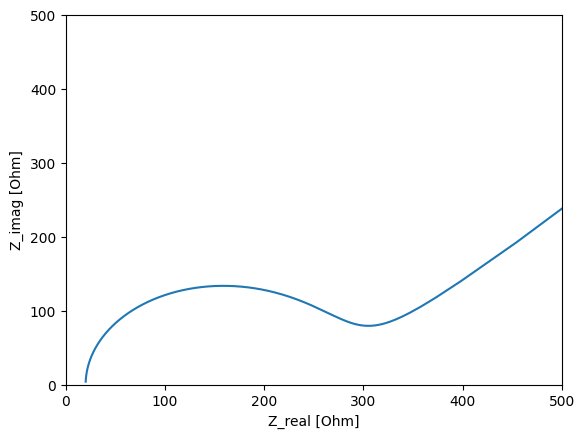

In [243]:
# plot
params = [20, 250, 40e-6, 150]
test_freq = np.linspace(0.001, 1000, num=10000) # Hz
print(test_freq.shape)
plt.plot(np.real(impedance_model(test_freq, *params)), -1*np.imag(impedance_model(test_freq, *params)), label='estimated')
plt.xlabel('Z_real [Ohm]')
plt.ylabel('Z_imag [Ohm]')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.show()